<a href="https://colab.research.google.com/github/HellenNamulinda/zindi-competitions/blob/master/makerere_fall_armyworm_crop_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Description**
Fall armyworm is a devastating pest in Africa, where it has no natural predators - African farmers say the pest causes average maize losses of 31% annually. Maize is the most widely grown crop in Africa and a staple for around half the continent’s people - over 300 million Africans depend on the crop for food and nutritional security. For smallholder farmers in particular, maize is popular for its wide adaptability, valuable by-products and high yields.

Because of this reliance on staple crops for food security, Viral pests and diseases like fall armyworm are one of the leading causes of food insecurity and poverty in Africa. Thus there is an urgent need to design early intervention mechanisms to help prevent crop losses for smallholder farmers.

In this challenge, your objective is to classify if a plant has been affected by a fall armyworm. This is a binary image classification challenge. The solution will be deployed as part of a mobile-based edge application which can be used by smallholder farmers in Uganda and the rest of Africa to carry out field-based diagnosis and intervene before fall armyworm devastates their maize crop for the season.

---
 
**Link to Chanllenge:** https://zindi.africa/competitions/makerere-fall-armyworm-crop-challenge

---



In [1]:
!pip install -q --upgrade fastcore fastai

     |████████████████████████████████| 59 kB 4.1 MB/s 
     |████████████████████████████████| 197 kB 15.6 MB/s 


## **Importing the necessary libraries**

In [2]:
import pandas as pd
import requests

from tqdm.auto import tqdm
from fastai.vision.all import *

## **Data url and token**

In [3]:
data_url = 'https://api.zindi.africa/v1/competitions/makerere-fall-armyworm-crop-challenge/files/' # Data Url
file_names =['Images.zip','Train.csv','Test.csv'] # Files
token = {'auth_token': ''} # Auth token

## **Function to download data**

In [4]:
def zindi_data_downloader(url, token, file_name):
  # Print current download url and file
  print('URL: {}  '.format(url), 'File: {}'.format(file_name))
  # Get the competition data
  competition_data = requests.post(url = url, data= token, stream=True)
  
  # Progress bar monitor download
  pbar = tqdm(desc=file_name, total=int(competition_data.headers.get('content-length', 0)), unit='B', unit_scale=True, unit_divisor=512)
  # Create and Write the data to colab drive in chunks
  handle = open(file_name, "wb")
  for chunk in competition_data.iter_content(chunk_size=512): # Download the data in chunks
      if chunk: # filter out keep-alive new chunks
              handle.write(chunk)
      pbar.update(len(chunk))
  handle.close()
  pbar.close()

In [5]:
#Downloading data
for file_name in file_names:
  zindi_data_downloader(data_url+file_name, token, file_name)

URL: https://api.zindi.africa/v1/competitions/makerere-fall-armyworm-crop-challenge/files/Images.zip   File: Images.zip


Images.zip:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

URL: https://api.zindi.africa/v1/competitions/makerere-fall-armyworm-crop-challenge/files/Train.csv   File: Train.csv


Train.csv:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

URL: https://api.zindi.africa/v1/competitions/makerere-fall-armyworm-crop-challenge/files/Test.csv   File: Test.csv


Test.csv:   0%|          | 0.00/44.3k [00:00<?, ?B/s]

In [6]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

print('Training shape: {}'.format(train.shape))
print('Testing shape: {}'.format(test.shape))

Training shape: (1619, 2)
Testing shape: (1080, 1)


In [7]:
train.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


In [8]:
test.head()

,Image_id
0,id_00exusbkgzw1b.jpg
1,id_03dqinf6w0znv.jpg
2,id_046yl0cxn3ybz.jpg
3,id_04athdtx2abyg.jpg
4,id_062aauf9e9jk0.jpg


In [9]:
# Unzip images
import os
os.mkdir('Images')

!unzip -q Images.zip -d 'Images'

In [10]:
# Generating labels for train and sets
train_x= train['Image_id'].map(lambda s: 'Images/{}'.format(s)).values
train_y = train['Label']

test_x = test['Image_id'].map(lambda s: 'Images/{}'.format(s)).values 

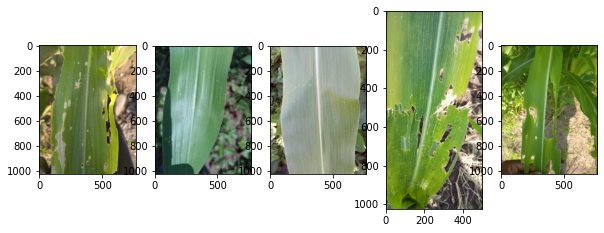

In [11]:
fig, axs = plt.subplots(1,5,figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    img = plt.imread(train_x[i])
    ax.imshow(img)
plt.show()

## Define the image data loader

In [12]:
img = PILImage(PILImage.create(img))

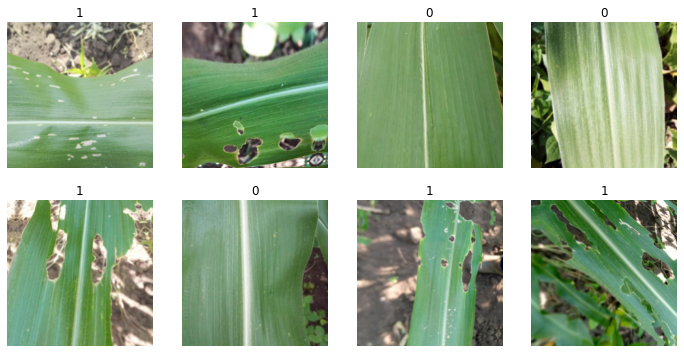

In [13]:
# Define the augmentation pipeline
transforms = aug_transforms(max_rotate=180, max_zoom=1.15, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)
batch_tfms = [*aug_transforms(size=224, max_warp=.35), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(224, min_scale=0.75, ratio=(1.,1.))
bs=8 # batch_size

# Load the images to the image data loader via the augmentation pipeline and receive augmented images
dls = ImageDataLoaders.from_lists('.', train_x, train_y,  batch_tfms=batch_tfms,  ds_tfms=transforms,
                                   item_tfms=item_tfms, bs = bs)
dls.show_batch()

## Using the Resnet50 pretrained model

In [14]:
roc = RocAucBinary()
learn = vision_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), ps=0.015, metrics=[accuracy, error_rate, roc]) # ps was used to split the dataset into: Training set(99,5%), Validation set(1,5%)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Fine tune the model

SuggestedLRs(valley=0.00019054606673307717)

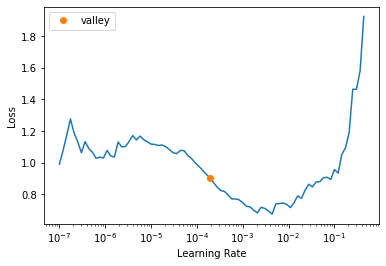

In [15]:
# Find the optimal lr using lr_find()
learn.lr_find()

In [17]:
# fine tune the model for 3 epochs, with learning rate and 1 freeze epoch
learn.fine_tune(3, base_lr=1e-4) 

epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,time
0,0.257307,0.055888,0.984520,0.015480,0.998811,00:41


epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,time
0,0.136137,0.039046,0.987616,0.012384,0.998581,00:40
1,0.103935,0.021834,0.993808,0.006192,0.999808,00:40
2,0.158973,0.026991,0.993808,0.006192,0.999770,00:40


## Final Evaluation

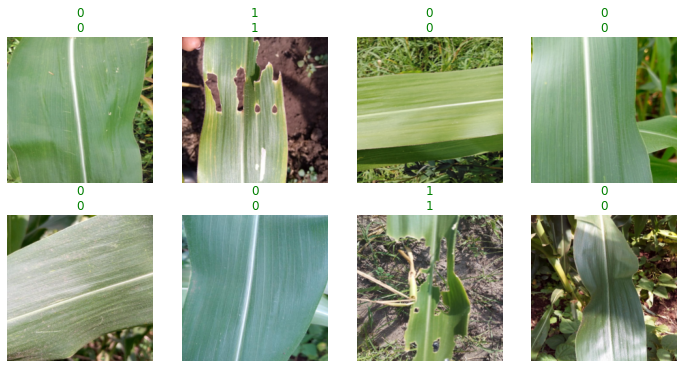

In [18]:
learn.show_results(ds_idx=1, dl=None, max_n=9, shuffle=True)

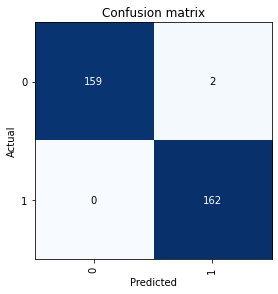

In [19]:
# create the interepreation object from our model
interep = ClassificationInterpretation.from_learner(learn)

# Plot the confusion matrix
interep.plot_confusion_matrix()

## Getting the predicted probabilities

In [20]:
preds = learn.get_preds(dl=dls.test_dl(test_x))  

In [21]:
test['Target']  = [float(p[1]) for p in preds[0]] # To get the predicted probs

test.head()

,Image_id,Target
0,id_00exusbkgzw1b.jpg,0.272048
1,id_03dqinf6w0znv.jpg,0.000120
2,id_046yl0cxn3ybz.jpg,1.000000
3,id_04athdtx2abyg.jpg,0.000004
4,id_062aauf9e9jk0.jpg,0.017091


In [22]:
# Save
test.to_csv('submission3.csv', index=False)